<a href="https://colab.research.google.com/github/kunal-git-002/object-detection/blob/master/using%20detectron%202/Object_Detection_using_Detectron_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using Detectron 2

In [70]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [71]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [72]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

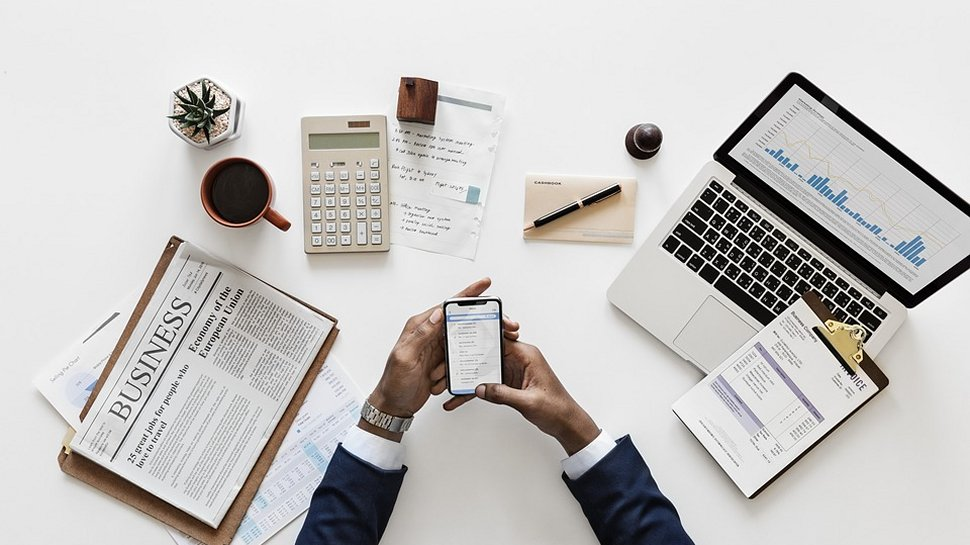

In [73]:
im=cv2.imread("/content/drive/My Drive/yolov3/sample datas/office2.jpg")

cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [74]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [75]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0, 63, 73, 67, 33, 73, 73], device='cuda:0')
Boxes(tensor([[294.7653, 279.5107, 692.8348, 538.2096],
        [612.0405,  72.7433, 970.0000, 381.2566],
        [ 52.7047, 232.7131, 341.2726, 537.4649],
        [444.8463, 299.7056, 501.9800, 399.7349],
        [168.5952,  78.7252, 234.8539, 146.9421],
        [666.9012, 298.5618, 890.5764, 510.1639],
        [622.2482,  95.2727, 959.4996, 385.0596]], device='cuda:0'))


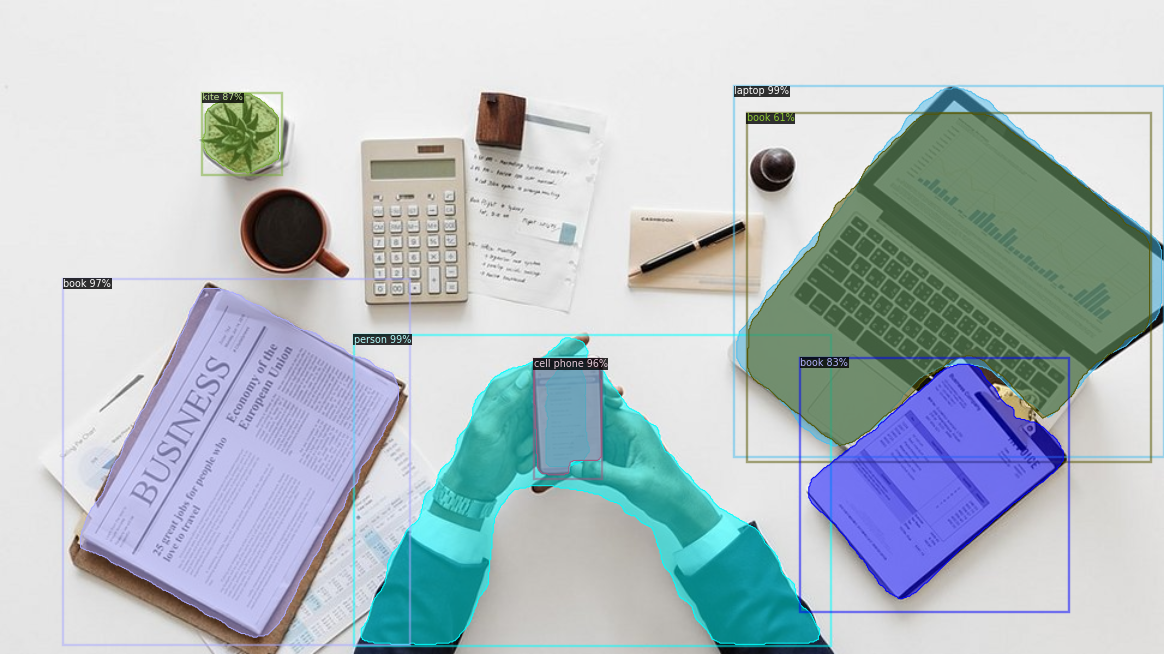

In [76]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# object detection using detectron 2, my way


two way to extract data

>outputs["instances"].pred_boxes

> outputs["instances"].get_fields()["pred_boxes"]





In [77]:
outputs["instances"].get_fields().keys()
#(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])

dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])

convert data into simple form

> 'pred_boxes', 'scores', 'pred_classes'



In [78]:
#1 pred_boxes
pred_boxes_box=outputs["instances"].pred_boxes
pred_boxes=[]
for i in pred_boxes_box:

  i = i.cpu().data.numpy()#data is first moved to cpu and then converted to numpy array
  i=list(i)#covert data in list

  pred_boxes.append(i)

#2 scores
scores=outputs["instances"].scores
scores=scores.cpu().data.numpy()
scores=list(scores)

#3 pred_classes
pred_classes=outputs["instances"].pred_classes
pred_classes=pred_classes.cpu().data.numpy()
pred_classes=list(pred_classes)

#4 class names
class_names=[]
file=open("/content/drive/My Drive/yolov3/coco.names","r")
for i in file:
  j=i.split("\n")[0]
  class_names.append(j)
file.close()


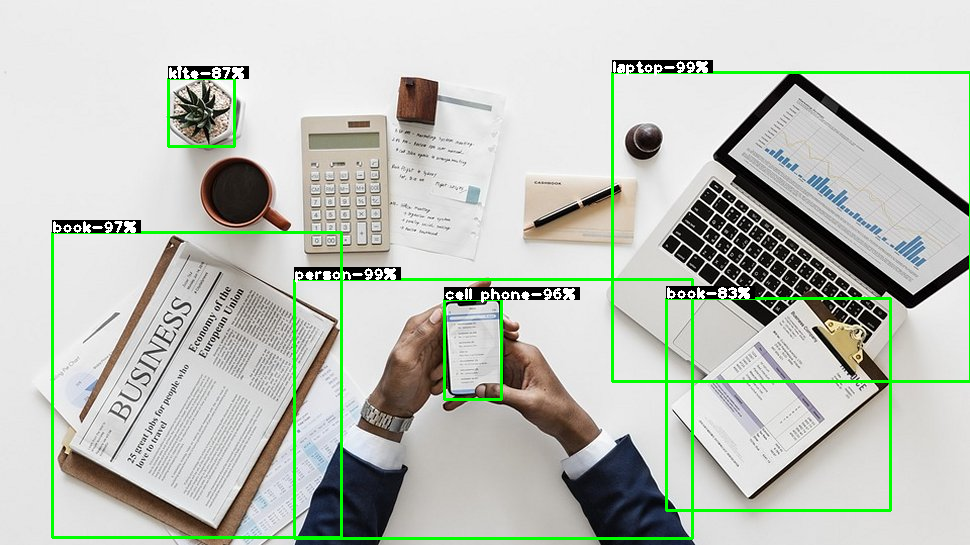

In [79]:
fm=im
red=(0,0,255)
blue=(255,0,0)
green=(0,255,0)
ht=1
th=2


for i in range(len(pred_classes)):

  #draw a bbox
  x1,y1,x2,y2=pred_boxes[i] 
  #label
  class_id=pred_classes[i]
  obj_name=class_names[class_id]
  #score
  score=scores[i]
  score=score*100
  score=int(round(score))

  if score>=70:

    cv2.rectangle(fm,(x1,y1),(x2,y2),green,th)
  
    label=obj_name+"-"+str(score)+"%"
    font=cv2.FONT_HERSHEY_PLAIN
    x1,y1=int(x1),int(y1)

    t_w,t_h=cv2.getTextSize(label, font,ht, th)[0]

    # make the coords of the box with a small padding of two pixels
    box_coords = ((x1,y1), (x1 + t_w + 2, y1 - t_h - 2))
    cv2.rectangle(fm,box_coords[0],box_coords[1],(0,0,0),-1)

    cv2.putText(fm,label,(x1,y1),font,ht,(255,255,255),th)
  else:
    pass

cv2_imshow(fm)